In [1]:
import ase
import ase.io
import bokeh
from bokeh.io import show
import functools
import jax
import jax.numpy as jnp
import matscipy.neighbours
import numpy as np
import pandas as pd
import pcax
import pickle
import pymatgen
from pymatgen.core import Lattice, Molecule, Structure
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import os
import random
import tqdm
import sys

from analyses.nearest_neighbors import CrystalNN, VoronoiNN
from analyses import metrics
import symphony.models.ptable as ptable
sys.path.append('/home/songk/pyspectra/')
import pyspectra
import pyspectra.spectra
import pyspectra.utils
import pyspectra.visualize

sys.path.append('/home/songk/cmap_periodictable/')
from ptable_trends import ptable_plotter

## Bispectra

### Get data

In [2]:
xyzs_path = "../tmqm_data/xyz"
mols_tmqm_ase = []
for mol_file in tqdm.tqdm(os.listdir(xyzs_path)):
    mol_as_ase = ase.io.read(os.path.join(xyzs_path, mol_file), format="xyz")
    if mol_as_ase is None:
        continue
    mols_tmqm_ase.append(mol_as_ase)

  0%|          | 0/86665 [00:00<?, ?it/s]

100%|██████████| 86665/86665 [00:15<00:00, 5589.74it/s]


In [3]:
def is_transition_metal(z):
    return 2 <= ptable.groups[z-1] <= 11

In [4]:
mols_tmqm = []
for mol in tqdm.tqdm(mols_tmqm_ase):
    struct = Molecule(mol.get_chemical_symbols(), mol.get_positions())
    mols_tmqm.append(struct)

100%|██████████| 86665/86665 [00:49<00:00, 1758.50it/s]


In [ ]:
mols_by_el = {}

for mol in tqdm.tqdm(mols_tmqm):
    el = ""
    for i in range(len(mol.numbers)):
        if is_transition_metal(mol.numbers[i]):
            el = mol.get_chemical_symbols()[i]
            break
    if el == "": continue
    struct = Molecule(mol.get_chemical_symbols(), mol.get_positions())
    mols_by_el[el] = mols_by_el.get(el, []) + [(struct, i)]

100%|██████████| 86665/86665 [16:14<00:00, 88.95it/s]  


In [5]:
generated_dirs = ["../analyses/analysed_workdirs/tmqmg_apr10_500k/Ni", "../analyses/analysed_workdirs/tmqmg_apr10_500k/W"]
mols_generated = []
for generated_dir in generated_dirs:
    for mol_file in tqdm.tqdm(os.listdir(generated_dir)):
        if mol_file.endswith(".xyz"):
            mol_as_ase = ase.io.read(os.path.join(generated_dir, mol_file), format="xyz")
            if mol_as_ase is None:
                continue
            mols_generated.append(Molecule(mol_as_ase.get_chemical_symbols(), mol_as_ase.get_positions()))

100%|██████████| 500/500 [00:00<00:00, 1526.37it/s]


In [6]:
import pickle
# with open("mols_by_el.pkl", "wb") as f:
#     pickle.dump(mols_by_el, f)

with open("mols_by_el.pkl", "rb") as f:
    mols_by_el = pickle.load(f)

### Get bispectra

In [7]:
def cutoff(mol, site_index, cutoff=3.):
    return mol.get_neighbors(mol[site_index], cutoff)

def cutoff_constructor(c):
    return functools.partial(cutoff, cutoff=c)

def get_chemical_symbols(mol):
    return [el.label for el in mol]

def get_neighbors(mol, site_index, cutoff=3.):
    return [x.label for x in mol.get_neighbors(mol[site_index], cutoff)]

In [8]:
def get_bispectrum_by_el(mol, el, cutoff=3.):
    spectra_comp = pyspectra.spectra.Spectra()
    spectra_comp.set_cutoff(cutoff_constructor(cutoff))
    spectra_comp.load_structure(mol)
    bispectrum = spectra_comp.compute_element_spectra(el)
    return jnp.array(list(bispectrum.values())), list(bispectrum.keys())

def get_bispectra_by_el_pair(mols, center_el, neighbor_el, cutoff=3.):
    bispectra = []
    for mol in tqdm.tqdm(mols):
        if center_el in get_chemical_symbols(mol):
            spectra, sites = get_bispectrum_by_el(mol, center_el, cutoff)
            for s, i in zip(spectra, sites):
                if neighbor_el in get_neighbors(mol, i, cutoff):
                    bispectra.append(s)
    return jnp.array(bispectra)

### Get MMD

In [9]:
center_el = 'C'
neighbor_el = 'C'

bispectra_generated = get_bispectra_by_el_pair(mols_generated, center_el, neighbor_el)
bispectra_tmqm = []
for i in jax.random.permutation(jax.random.PRNGKey(0), jnp.arange(len(mols_tmqm)))[:1000]:
    bispectra_tmqm.append(get_bispectra_by_el_pair([mols_tmqm[i]], center_el, neighbor_el))
# bispectra_tmqm = get_bispectra_by_el_pair(
#     mols_tmqm[jax.random.permutation(jax.random.PRNGKey(0), jnp.arange(len(mols_tmqm)))[:1000]],
#     center_el, neighbor_el)
# bispectra_tmqm = get_bispectra_by_el_pair([m for m, _ in mols_by_el[center_el]], center_el, neighbor_el)

  0%|          | 0/1000 [00:00<?, ?it/s]


XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777828 bytes.

In [ ]:
key_1, key_2 = jax.random.split(jax.random.PRNGKey(0))

n_samples = 25
sampled_bispectra_generated = jax.random.choice(key_1, bispectra_generated, shape=(n_samples,), replace=False)
sampled_bispectra_tmqm = jax.random.choice(key_2, bispectra_tmqm, shape=(n_samples,), replace=False)

ValueError: Cannot take a larger sample than population when 'replace=False'

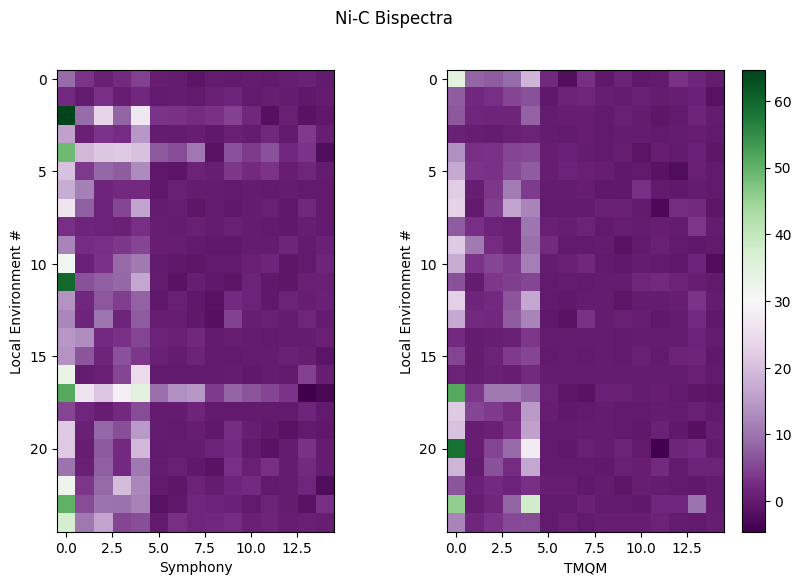

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
vmin = min(sampled_bispectra_generated.min(), sampled_bispectra_tmqm.min())
vmax = max(sampled_bispectra_generated.max(), sampled_bispectra_tmqm.max())
ax[0].imshow(
    sampled_bispectra_generated, cmap="PRGn", vmin=vmin, vmax=vmax
)
ax[0].set_xlabel("Symphony")
ax[0].set_ylabel("Local Environment #")

im = ax[1].imshow(
    sampled_bispectra_tmqm, cmap="PRGn", vmin=vmin, vmax=vmax
)
ax[1].set_xlabel("TMQM")
ax[1].set_ylabel("Local Environment #")

fig.colorbar(im, ax=ax[1])
fig.suptitle(f"{center_el}-{neighbor_el} Bispectra")

fig.show()
fig.savefig(f"plots/tmqm_bispectra/{center_el}_{neighbor_el}_bispectra.png")

In [66]:
import rdkit.Chem as Chem
from openbabel import openbabel
complex = Chem.MolFromSmiles("[Zn--]([NH3+])([NH3+])([NH3+])N1C=C(Cl)N=C1")

ModuleNotFoundError: No module named 'openbabel'

In [65]:
for atom in openbabel.OBMolAtomIter(mol):
        atomic_num = atom.GetAtomicNum()
        atomic_symbol = openbabel.GetSymbol(atomic_num)
        atom_valency = atom.GetExplicitValence()
        if atom_valency != expected_valences[atomic_symbol]:
            invalid = True
            break

In [61]:
Chem.rdDetermineBonds.DetermineBonds(complex, charge=0)

ValueError: determineBondOrdering() does not work with element Zn